In [1]:
from google.colab import drive
drive.mount('/content/drive/')
# Load the TensorBoard notebook extension
%load_ext tensorboard

Mounted at /content/drive/


In [2]:
import os

In [3]:
#CONSTANTS - working with files
ROOT_DIRECTORY = os.path.join("drive", "My Drive", "Colab Notebooks", "working")
#ROOT_DIRECTORY = os.path.join(".")
import sys
sys.path.append(ROOT_DIRECTORY)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import time
import math
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.metrics import SparseCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from utils.files import *
from utils.BoundingBox import *
from utils.visualize import *

In [5]:
#reproducability!
random_seed = 27
import random
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [6]:
# CONSTANTS
DATASETS_DIR = os.path.join(ROOT_DIRECTORY, "datasets")
LOGS_DIR = os.path.join(ROOT_DIRECTORY, "logs")
MODELS_DIR = os.path.join(ROOT_DIRECTORY, "models")

TRAIN_PERCENTAGE = 0.8
VALIDATION_PERCENTAGE = 0.1
TEST_PERCENTAGE = 0.1

IMAGE_SIZE = (224, 224, 3)

BATCH_SIZE = 16

In [7]:
def get_timestamp():
    return time.strftime("%m.%d-%H.%M.%S")

def get_log_dir(model_name):
    return os.path.join(LOGS_DIR, f"{model_name}_{get_timestamp()}")

def get_models_dir(model_name):
    return os.path.join(MODELS_DIR, f"{model_name}_{get_timestamp()}")

# White Cells Classification

## Introduction

The count of different types of blood cells is a widely used to detect abnormalities and to diagnose different diseases. For example, WBCs are an important part of the immune system and having a higher or lower number of WBCs than normal may indicate an underlying immune deficiency. Based on four different datasets with annotated images with blood smears, we try to classify the different types of white cells. Unfortunately, there are still not any at least a little bit satisfying results. It is necessary that further tests, investigation and improvements to be made.


## Data analysis and initial data preparation

We have already discussed and combined the used datasets in the initial notebook "Exploratory Data Analysis"

In [8]:
ds = pd.read_csv(os.path.join(DATASETS_DIR, "cells.csv"))
wbcs_ds = ds[(ds.label != "rbc") & (ds.label != 'platelets')]
wbcs_ds

,image_filepath,mask_filepath,dataset,label,xmin,ymin,xmax,ymax
0,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,neutrophil,260,177,491,376
20,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,neutrophil,68,315,286,480
39,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,neutrophil,283,1,567,106
55,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,neutrophil,127,40,344,226
72,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,neutrophil,109,134,324,321
...,...,...,...,...,...,...,...,...
5509,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset4,basophil,120,475,202,562
5510,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset4,basophil,134,350,218,433
5511,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset4,basophil,240,252,319,347
5512,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset4,basophil,316,222,413,304


In [9]:
wbcs_types = np.unique(wbcs_ds.label)
wbcs_types

array(['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil'],
      dtype=object)

### Encoding white cell types


We want to encode our labels - the white cell types, as we can only use numbers in our neural network models. 

In [10]:
cells_types_map = {
     "lymphocyte": 0,
     "basophil": 1,
     "monocyte": 2,
     "neutrophil": 3,
     "eosinophil": 4
}

# used for visualization purposes
decoding_cells_types_map = {
     0: "lymphocyte",
     1: "basophil",
     2: "monocyte",
     3: "neutrophil",
     4: "eosinophil"
}

In [11]:
wbcs_ds.label = wbcs_ds.label.map(cells_types_map)
wbcs_ds

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,image_filepath,mask_filepath,dataset,label,xmin,ymin,xmax,ymax
0,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,3,260,177,491,376
20,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,3,68,315,286,480
39,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,3,283,1,567,106
55,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,3,127,40,344,226
72,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset1,3,109,134,324,321
...,...,...,...,...,...,...,...,...
5509,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset4,1,120,475,202,562
5510,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset4,1,134,350,218,433
5511,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset4,1,240,252,319,347
5512,drive/My Drive/Colab Notebooks/working/dataset...,drive/My Drive/Colab Notebooks/working/dataset...,Dataset4,1,316,222,413,304


### Train-validation-test data split

We try to preserve the same proportions of examples in each class in the split train, validation and test datasets, as observed in the original dataset (stratified split).

In [12]:
def split_data(dataset, target_name, train_percent, validation_percent):
    train_data = pd.DataFrame()
    val_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for (label, group_elements) in dataset.groupby(target_name):
        count = len(group_elements)
        group_elements = group_elements.sample(count) #shuffle

        train_data_end_index = int(count * train_percent)
        val_data_end_index = train_data_end_index + int(count * validation_percent)

        train_data_in_group = group_elements[:train_data_end_index]
        val_data_in_group = group_elements[train_data_end_index:val_data_end_index]
        test_data_in_group = group_elements[val_data_end_index:]

        train_data = train_data.append(train_data_in_group)
        val_data = val_data.append(val_data_in_group)    
        test_data = test_data.append(test_data_in_group)
        
    return (train_data, val_data, test_data)

Now, we can perpare and split the data.

In [13]:
train_data, val_data, test_data = split_data(wbcs_ds, "label", TRAIN_PERCENTAGE, VALIDATION_PERCENTAGE)

Let's double check the sizes and whether they are properly shuffled across the different datasets.

In [14]:
print("Train set size:", train_data.shape)
print("Validation set size:", val_data.shape)
print("Test set size:", test_data.shape)

Train set size: (796, 8)
Validation set size: (98, 8)
Test set size: (104, 8)


Let's also check the representation of the different subdatasets in the train-validation-test split. They seem somwhat proportioned.

In [15]:
def get_groups_elements_count_by_attribute_values(current_df, attribute):
  groups = []
  for key, gr in current_df.groupby(attribute):
    groups.append(len(gr))
  return groups

def show_percentage(data, base_datasets_length, dataset_name):

  other_ds1, other_ds2, other_ds3, other_ds4 = get_groups_elements_count_by_attribute_values(data, "dataset")
  percent = lambda a, b : float(a/b)*100

  print(f"{dataset_name} dataset1: {percent(other_ds1, ds1):.2f} %")
  print(f"{dataset_name} dataset2: {percent(other_ds2, ds2):.2f} %")
  print(f"{dataset_name} dataset3: {percent(other_ds3, ds3):.2f} %")
  print(f"{dataset_name} dataset4: {percent(other_ds4, ds4):.2f} %")

ds1, ds2, ds3, ds4 = get_groups_elements_count_by_attribute_values(wbcs_ds, "dataset")

show_percentage(train_data, (ds1, ds2, ds3, ds4), "Train")
print()
show_percentage(val_data, (ds1, ds2, ds3, ds4), "Validation")
print()
show_percentage(test_data, (ds1, ds2, ds3, ds4), "Test")
print()

Train dataset1: 80.54 %
Train dataset2: 78.00 %
Train dataset3: 81.82 %
Train dataset4: 79.91 %

Validation dataset1: 6.76 %
Validation dataset2: 13.33 %
Validation dataset3: 12.12 %
Validation dataset4: 9.17 %

Test dataset1: 12.70 %
Test dataset2: 8.67 %
Test dataset3: 6.06 %
Test dataset4: 10.92 %



### Unbalanced dataset

Let's first look at the distribution of classes in our dataset. We can see that there are very inpalanced, e.g. for Basophiles there is really small number of examples and we should take that into consideration in the further processing.

(0, 172)
(1, 58)
(2, 133)
(3, 472)
(4, 163)


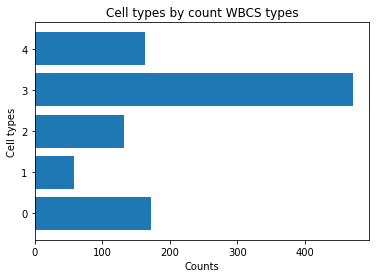

In [16]:
show_barplot_celltypes(wbcs_ds, "WBCS types")

As our dataset is very unbalanced, we will want to have a classifier that will heavily weight the few examples that are available for the white cells types that less than the others. We can do this by passing a parameter 'class weights' for each class to the model.fit(...). These will cause the model to "pay more attention" to the examples from an under-represented class.

In [17]:
total_count = wbcs_ds.shape[0]

class_weights = {}
print("Original classes counts:")
for key, gr in wbcs_ds.groupby("label"):
    print(key, ":", len(gr))
    # Scaling by total/2 helps keep the loss to a similar magnitude.
    # The sum of the weights of all examples stays the same.

    weight = (1/len(gr)) * (total_count/2)
    class_weights[key] = weight
    
print()
print("Calculated class weights:")
class_weights

Original classes counts:
0 : 172
1 : 58
2 : 133
3 : 472
4 : 163

Calculated class weights:


{0: 2.9011627906976742,
 1: 8.60344827586207,
 2: 3.75187969924812,
 3: 1.0572033898305084,
 4: 3.061349693251534}

### Preprocessing of data (with tf.data.Dataset API)



#### Preprocessing

Usually in the traditional machine learning we try to zero-center and normalize the input data so all the features are the same range and they contribute equally. However for the images we do zero centering, but not so much normalization. In CNN we rely on the filters on the original images to extract the features, not to project the data on another feature space such as PCA. Also, we can also subtract the mean image (AlexNet) or per-channel mean (VGG).

So we will normalize the pixel values between 0 and 1, as NNs use small weight values and inputs with large integer values can disrupt or slow down the learning process (dividing all pixels values by the largest pixel value(255) across all channels).

In [18]:
def read_tf_image(image_filename, cell_type): 
    image_file = tf.io.read_file(image_filename)
    image = tf.image.decode_image(image_file)
    image = tf.image.convert_image_dtype(image, tf.float32)
    w, h = IMAGE_SIZE[:2]
    image = tf.image.resize_with_pad(image, h, w)

    # scale
    image = image / 255.0
    # one-hot encoded
    cell_type = tf.one_hot(cell_type, len(wbcs_types), on_value = 1.0, off_value = 0.0, axis =-1) 

    return (image, cell_type)

#### Tensorflow Data Dataset API

Also, we will use tf.data / tf.image APIs which are designed to build flexible and efficient input pipelines, optimised to work on modern GPUs and TPUs. The pipeline delivers data for the next step before the current step has finished. 

For example, tf.image pipeline might aggregate data from files in a distributed file system, apply random transformations to each image, and merge randomly selected images into a batch for training. And all the computation is done on GPU

The tf.data API also introduces a tf.data.Dataset abstraction that represents a sequence of elements, in which each element consists of one or more components. 
So, we will construct our tf.data.Dataset datasets for training/validation/test retrieving the necessary information from the pandas dataset.

Let's check whether everything is read correctly for the different types of images from the different datasets.

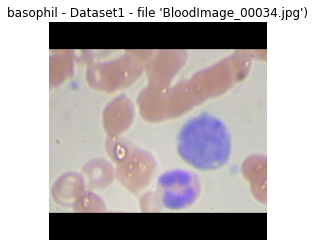

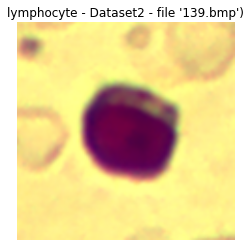

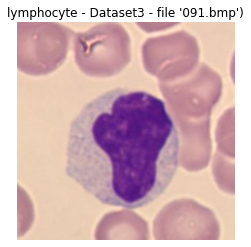

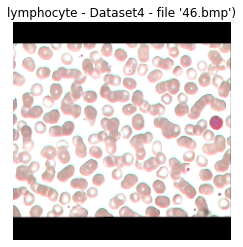

In [19]:
def show_images_from_dataset_grouped_by_attribute(dataset, attribute):
    for key, gr in dataset.groupby(attribute):
        sample_data_row = gr.iloc[27]
        sample_image, label = read_tf_image(sample_data_row.image_filepath, sample_data_row.label)
        cell_type = decoding_cells_types_map[np.argmax(label)]
        show_image(np.array(sample_image)*255,
                   f"{cell_type} - {key} - file '{os.path.basename(sample_data_row.image_filepath)}')")

show_images_from_dataset_grouped_by_attribute(train_data, "dataset")

Here is how we will create our tf.data.Dataset:
 - we call our transformation for each image (scaling between 0, 1 and resizing) in the loaded dataset
 - make batches of BATCH_SIZE
 - if we want to create and infinite dataset we can use repeat()

In [20]:
def get_tf_finite_dataset(data, read_image_func):
    ds = tf.data.Dataset.from_tensor_slices((
        data.image_filepath.values, 
        data.label.values))   
    ds = ds.map(read_image_func)
    ds = ds.batch(BATCH_SIZE)
    return ds

def get_tf_infinite_dataset(data, read_image_func):
    ds = get_tf_finite_dataset(data, read_image_func)
    ds = ds.repeat()
    return ds

## Modelling

### Custom CNN model



First let's try to create a very simple custom convolutional neural network classify the white cells.


#### Data - proof of concept dataset with 10 samples of the data

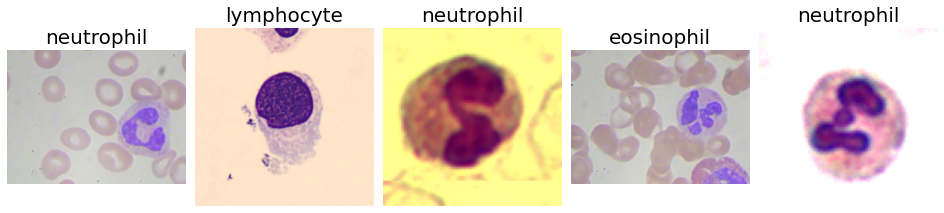

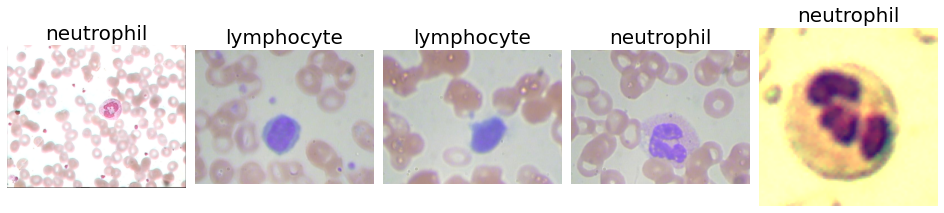

In [21]:
poc_data_sample = train_data.sample(10, random_state=random_seed)
def show_images_from_dataset(ds):
  sample_images = [read_image(im) for im in ds.image_filepath]
  sample_labels = [decoding_cells_types_map[l] for l in ds.label]
  show_images(sample_images, sample_labels)

show_images_from_dataset(poc_data_sample.iloc[0:5])
show_images_from_dataset(poc_data_sample.iloc[5:10])

In [22]:
poc_dataset = get_tf_infinite_dataset(poc_data_sample, read_tf_image)

#### Model - a basic custom CNN model

We have created a very basic CNN that has a few convolution layers and two dense layers at end, the last one with softmax for classifying the data.

Remarks:
- We added Batch normalizaion as improves gradient flow through the network and reduces the strong dependence on the initialization. Actually, batch normalization force the intermediate activation to be zero mean and unit variation.
- We also have tried to set the kernel initializers with our random seeds, although it doesn't help for everything to be fully reproducable. Probably there are more missed random seeds.

In [23]:
tf.keras.backend.clear_session() # if the order of the execution of the cells is different from top to bottom

def get_custom_cnn():
    
    def CustomConv2D(filters):
        return Conv2D(filters, 
                      kernel_size = (3, 3), 
                      padding = "same", 
                      activation = tf.nn.relu, 
                      kernel_initializer = HeNormal(seed=random_seed))
        
  
    return Sequential([
    
    Input(IMAGE_SIZE),

    CustomConv2D(32),
    CustomConv2D(32),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    
    CustomConv2D(64),
    CustomConv2D(64),
    MaxPool2D((2, 2)),
    BatchNormalization(),

    CustomConv2D(128),
    CustomConv2D(128),
    MaxPool2D((2, 2)),
    BatchNormalization(),

    CustomConv2D(256),
    CustomConv2D(256),
    MaxPool2D((2, 2)),
    BatchNormalization(),

    CustomConv2D(512),
    CustomConv2D(512),
    MaxPool2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    
    Dense(10, activation = tf.nn.relu,
          kernel_initializer=HeNormal(seed=random_seed)),
    Dropout(0.1, seed=random_seed),
    Dense(len(wbcs_types), activation = tf.nn.softmax,
          kernel_initializer=HeNormal(seed=random_seed))
  ])

In [24]:
poc_cnn = get_custom_cnn()
poc_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0

#### Train with POC dataset

Now, let's compile the model and fit the training data with it.
We again use the base parameters:
- adam optimizer with default learnning rate = 0.01
- loss - sparse categorical entropy (we did not hot-encoded the labels)
- accuracy as a metric


In [25]:
poc_cnn.compile(
    optimizer = Adam(learning_rate=1e-3), 
    loss = CategoricalCrossentropy(from_logits=False),
    metrics = [CategoricalAccuracy()])

In [26]:
history_poc_cnn = poc_cnn.fit(
    poc_dataset, 
    epochs = 30, 
    steps_per_epoch = 15, 
    callbacks = [TensorBoard(get_log_dir("poc_cnn"))])

Epoch 1/30
15/15 [==============================] - 10s 101ms/step - loss: 1.6618 - categorical_accuracy: 0.4540
Epoch 2/30
15/15 [==============================] - 1s 90ms/step - loss: 1.0010 - categorical_accuracy: 0.6878
Epoch 3/30
15/15 [==============================] - 1s 90ms/step - loss: 0.8371 - categorical_accuracy: 0.6972
Epoch 4/30
15/15 [==============================] - 1s 90ms/step - loss: 0.8907 - categorical_accuracy: 0.6931
Epoch 5/30
15/15 [==============================] - 1s 90ms/step - loss: 0.9646 - categorical_accuracy: 0.7000
Epoch 6/30
15/15 [==============================] - 1s 91ms/step - loss: 0.8057 - categorical_accuracy: 0.7000
Epoch 7/30
15/15 [==============================] - 1s 93ms/step - loss: 0.8395 - categorical_accuracy: 0.6960
Epoch 8/30
15/15 [==============================] - 1s 90ms/step - loss: 0.7922 - categorical_accuracy: 0.6851
Epoch 9/30
15/15 [==============================] - 1s 90ms/step - loss: 0.8297 - categorical_accuracy: 0.6570

#### Visualizations

In [27]:
def plot_learning_curve(history, metric_name,  model_name):
    plt.figure(figsize=(16,8))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric_name])
    val_metric_name = f"val_{metric_name}"
    if val_metric_name in history.history:
        plt.plot(history.history[val_metric_name])
    plt.title(f'The {metric_name} of \'{model_name}\'')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    if "val_loss" in history.history:
        plt.plot(history.history['val_loss'])
    plt.title(f'The loss of \'{model_name}\'')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    

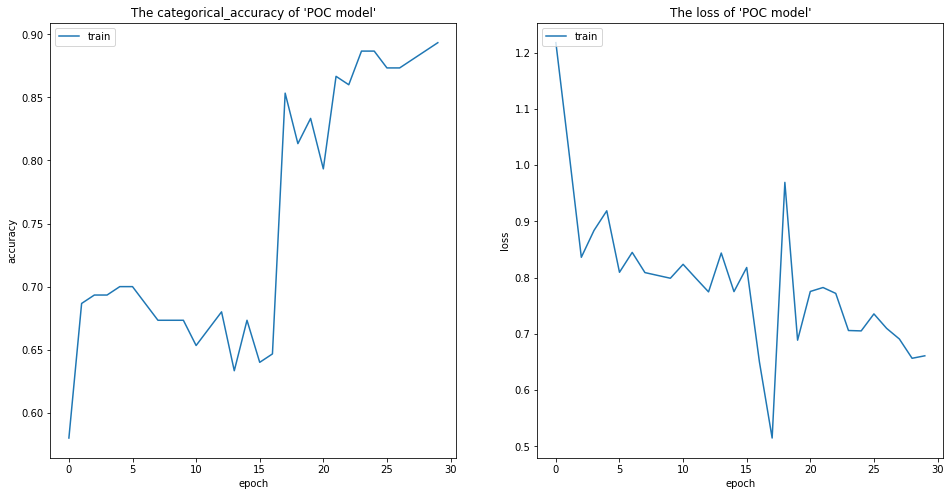

In [28]:
plot_learning_curve(history_poc_cnn, CategoricalAccuracy().name, "POC model")

In [29]:
poc_cnn.evaluate(poc_dataset, steps=1)

1/1 [==============================] - 0s 313ms/step - loss: 3.1195 - categorical_accuracy: 0.6000


[3.1195006370544434, 0.6000000238418579]

#### Comments

We succeeded to overfit our proof of concept little dataset and model. It was just for testing purposes that the basic workflow is working how it is expected.

#### Prepare all available data

Let's try with all the images from the dataset

In [30]:
# unmodified train datasets
train_ds = get_tf_finite_dataset(train_data, read_tf_image)
val_ds = get_tf_finite_dataset(val_data, read_tf_image)

test_ds = get_tf_finite_dataset(test_data, read_tf_image)

#### Train with the full train and validation datasets

In [31]:
tf.keras.backend.clear_session()

custom_cnn = get_custom_cnn()

In [32]:
epochs = 80

#learning_rate = 0.01
#decay_rate = learning_rate / epochs

#def exp_decay(epoch):
#    lrate = learning_rate * np.exp(- decay_rate * epoch)
#    return lrate

custom_cnn.compile(
    optimizer = Adam(learning_rate=1e-5),#SGD(learning_rate=1e-5, momentum=0.5, nesterov=False), 
    loss = CategoricalCrossentropy(from_logits=False),
    metrics = [CategoricalAccuracy()])

In [33]:
custom_cnn_h5 = get_models_dir("custom_cnn")

history_custom_model = custom_cnn.fit(
    train_ds,
    validation_data = val_ds,
    class_weight = class_weights,
    epochs = epochs, 
    callbacks = [         
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-15, verbose=1),
        #LearningRateScheduler(exp_decay),
        ModelCheckpoint(custom_cnn_h5, verbose=1, save_weights_only=True, save_freq="epoch"),
        TensorBoard(get_log_dir("custom_cnn"))])

Epoch 1/80
50/50 [==============================] - 329s 7s/step - loss: 6.8749 - categorical_accuracy: 0.3776 - val_loss: 1.6626 - val_categorical_accuracy: 0.1735

Epoch 00001: saving model to drive/My Drive/Colab Notebooks/working/models/custom_cnn_02.26-09.04.49
Epoch 2/80
50/50 [==============================] - 5s 108ms/step - loss: 5.0016 - categorical_accuracy: 0.2707 - val_loss: 2.0057 - val_categorical_accuracy: 0.1735

Epoch 00002: saving model to drive/My Drive/Colab Notebooks/working/models/custom_cnn_02.26-09.04.49
Epoch 3/80
50/50 [==============================] - 5s 107ms/step - loss: 3.9580 - categorical_accuracy: 0.3619 - val_loss: 2.4592 - val_categorical_accuracy: 0.1735

Epoch 00003: saving model to drive/My Drive/Colab Notebooks/working/models/custom_cnn_02.26-09.04.49
Epoch 4/80
50/50 [==============================] - 5s 108ms/step - loss: 3.7753 - categorical_accuracy: 0.4465 - val_loss: 2.9811 - val_categorical_accuracy: 0.1735

Epoch 00004: saving model to d

#### Visualizations and tests


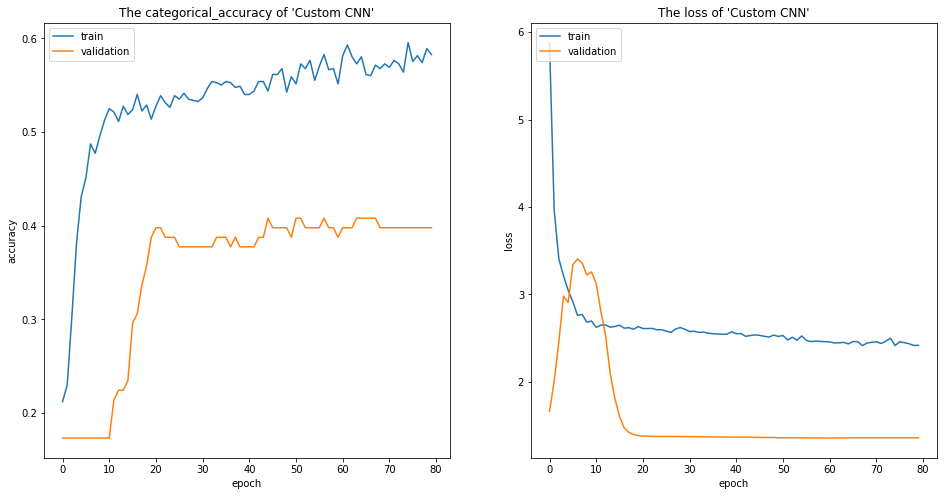

In [34]:
plot_learning_curve(history_custom_model, CategoricalAccuracy().name, "Custom CNN")

In [35]:
#custom_cnn.load_weights(os.path.join(ROOT_DIRECTORY, "custom_cnn.h5"))
#custom_cnn.save_weights(f"last_{custom_cnn_h5}")
custom_cnn.evaluate(test_ds)

7/7 [==============================] - 36s 5s/step - loss: 1.4564 - categorical_accuracy: 0.3269


[1.45643949508667, 0.32692307233810425]

In [36]:
def get_images_with_labels_from_iterator(it, count=None):
    images_with_labels = []

    c = 0
    for imgs, one_hot_labels in it:

        if count is not None and c > count:
          break;

        i = 0
        for img, one_hot_label in zip(imgs, one_hot_labels):
            
            label = np.argmax(one_hot_labels[i])
            img = np.array(img) * 255
            
            images_with_labels.append((img, label))
            i += 1
        c += 1

    return images_with_labels

In [37]:
def plot_confusion_matrix(original, predicted, num_classes):
    array = tf.math.confusion_matrix(original, predicted, num_classes).numpy()
  
    df_cm = pd.DataFrame(array, range(num_classes), range(num_classes))
    sn.set(font_scale = 1.4) 
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) 

    plt.show()

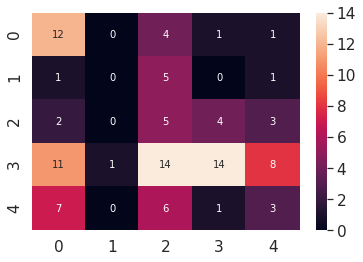

In [38]:
custom_cnn_predicted_labels_one_hot = custom_cnn.predict(test_ds)
custom_cnn_original_images_with_labels = get_images_with_labels_from_iterator(test_ds.as_numpy_iterator())

custom_cnn_original_labels = [l for (img, l) in custom_cnn_original_images_with_labels]
custom_cnn_predicted_labels = [np.argmax(l) for l in custom_cnn_predicted_labels_one_hot]

plot_confusion_matrix(custom_cnn_original_labels, custom_cnn_predicted_labels, len(wbcs_types))

The model does not learn anything. We still can look at some images but even if there are any matches, they seem to be random.

In [69]:
def show_predicted_images(test_ds, original_images_with_labels, predicted_one_hot, count):
    i = 0
    for img, label in original_images_with_labels:

        if(i == count):
          break

        print("Predicted probabilities:", predicted_one_hot[i])

        original_label = decoding_cells_types_map[label]            
        predicted_label = decoding_cells_types_map[np.argmax(predicted_one_hot[i])]

        title = f"org({original_label}) vs pred({predicted_label})"
        show_image(img, title)

        i+=1

Predicted probabilities: [0.17319424 0.010633   0.08346167 0.5761291  0.15658209]


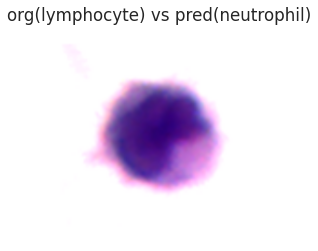

Predicted probabilities: [0.4548124  0.07177141 0.20011158 0.17197484 0.10132971]


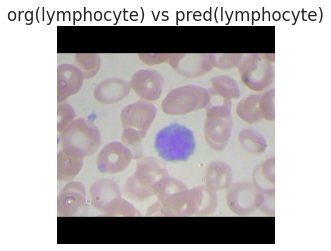

Predicted probabilities: [0.8687834  0.00546974 0.00142684 0.09952266 0.02479742]


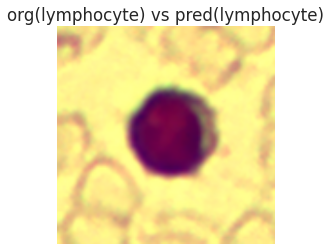

Predicted probabilities: [0.3498377  0.08507626 0.2905213  0.1714272  0.1031376 ]


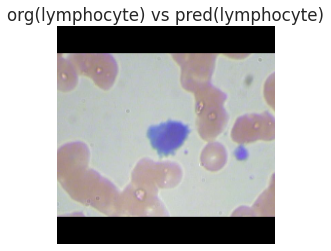

Predicted probabilities: [0.5540548  0.02814109 0.01734348 0.20199303 0.19846764]


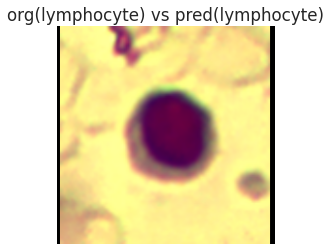

In [70]:
show_predicted_images(test_ds,
                      custom_cnn_original_images_with_labels,
                      custom_cnn_predicted_labels_one_hot, len(wbcs_types))

#### Comments

We see a tendency for the validation accuracy to increase and the loss to converge but it is not at all ok...

And the evaluation accuracy on the test data is a little bigger than the random guess -> 1/5 != (0.20-0.30).

The last epochs reach some plateau (around 1.238) even with the decreasing learning rate. Maybe, we can still fine tune the neural network architecture in order to reach some better converging model but for the current tackling the parameters (more nodes, layers, )it was the best result with our small dataset.

Maybe the dataset is too small and diverse for the NN to learn anything and we can try to use transfer learning together with some image augmentation techniques.

### CNNs with image Augmentation


#### Image Data Generator


We can try to simplify the dataset a little bit and use the other data that we have. 

If we only make a model for classification, we can augment using

- rotation - there is asymetry in some of the nuclei of the white cells
- flips - different position of the white cells
- brightness
- color variance - rgb channels as we can have different colorization, as it can be seen from the given datasets
- noise - add normal noise

In [42]:
image_generator = ImageDataGenerator(
        rotation_range = 15,
        horizontal_flip = True,
        vertical_flip = True,
        brightness_range = (0.4, 0.7),
        fill_mode = 'nearest') # better wrap for cells/nuclei but here there are some borders on some of the images

In [43]:
def plot_augmentation(datagen, data, n_rows=1, n_cols=5):
  image = read_image(data.image_filepath.iloc[3])
  image_new = image.reshape((1, ) + image.shape)

  generated_images = []
  
  it = datagen.flow(image_new)

  for i in range(0, 6):
    img = it.next()
    generated_img = img[0].astype('uint8')
    generated_images.append(generated_img.reshape(image.shape))
    if i > 5:
        break  # to stop the yielding generator
  show_images(generated_images, ["Generated"]*6)


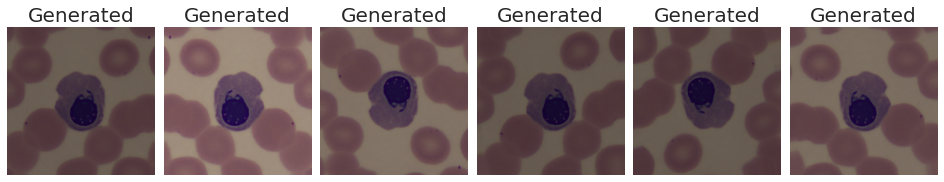

In [44]:
plot_augmentation(image_generator, train_data)

For ranging rgb channels and adding noise we will add a custom image generator:

In [45]:
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self,
               red_range = None,
               green_range = None,
               blue_range = None,
               gaussian_noise = None,
               **kwargs):
        super().__init__(
            preprocessing_function=self.update_image, **kwargs)
        self.red_range = red_range
        self.green_range = green_range
        self.blue_range = blue_range
        self.gaussian_noise = gaussian_noise

    def update_image(self, image):
        channel_ranges = [self.red_range, self.green_range, self.blue_range]
        defined_values = np.array([ch is not None for ch in channel_ranges])
        
        # update colour channels
        if defined_values.any():
            for channel, channel_range in enumerate(channel_ranges):
                if not channel_range:
                    continue 
                scale = random.uniform(channel_range[0], channel_range[1])
                image[:, :, channel] *= scale
            # clip the image to the standard interval of [0, 255].
            image = np.clip(image, 0, 255.0)

        # add gaussian noise
        if self.gaussian_noise is not None:
            gauss = np.random.normal(0, 1, image.shape)
            gauss = gauss.reshape(image.shape)
            image = image + gauss
        return image

In [46]:
custom_image_generator = CustomImageDataGenerator(
        rotation_range = 15,
        horizontal_flip = True,
        vertical_flip = True,
        #brightness_range = (0.4, 0.7),
        red_range = (0.8, 1.2),
        green_range = (0.8, 1.2),
        blue_range = (0.8, 1.2),
        #gaussian_noise = True,
        fill_mode = 'nearest') # better wrap for cells/nuclei but here there are some borders on some of the images

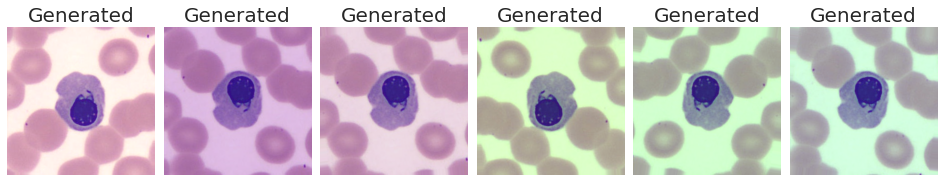

In [47]:
plot_augmentation(custom_image_generator, train_data)

In [48]:
"""
# There is an idea to simplify the data for test purposes - to process only the cells inside the bounding boxes

def read_tf_image_with_cropped_bb_and_one_hot_encoded_label(image_filename, xmin, ymin, xmax, ymax, cell_type): 

    image_file = tf.io.read_file(image_filename)
    image = tf.image.decode_image(image_file)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # crop to the bounding box
    print(image_filename)
    image = tf.image.crop_to_bounding_box(image, 
        tf.cast(ymin, tf.int32),
        tf.cast(xmin, tf.int32), 
        tf.cast(ymax-ymin, tf.int32), 
        tf.cast(xmax-xmin, tf.int32))
    w, h = IMAGE_SIZE[:2]
    image = tf.image.resize_with_pad(image, h, w)
    image = image / 255.0
    # one-hot encoded
    cell_type = tf.one_hot(cell_type, len(wbcs_types), on_value = 1.0, off_value = 0.0, axis =-1) 

    return (image, cell_type)

  for i in range(train_data_sample.shape[0]):
    sample_train_image, sample_train_label = read_tf_image_with_cropped_bb_and_one_hot_encoded_label(train_data_sample.iloc[i].image_filepath,
        train_data_sample.iloc[i].xmin,
        train_data_sample.iloc[i].ymin,
        train_data_sample.iloc[i].xmax,
        train_data_sample.iloc[i].ymax,
        train_data_sample.iloc[i].label)
    show_image(sample_train_image * 255, decoding_cells_types_map[np.argmax(sample_train_label)])

def get_tf_finite_dataset_with_bbs(data, read_image_func):
    ds = tf.data.Dataset.from_tensor_slices((
        data.image_filepath.values, 
        data.xmin.values,
        data.ymin.values,
        data.xmax.values,
        data.ymax.values,
        data.label.values))   
    ds = ds.map(read_image_func)
    ds = ds.batch(10)
    return ds


"""

'\n# There is an idea to simplify the data for test purposes - to process only the cells inside the bounding boxes\n\ndef read_tf_image_with_cropped_bb_and_one_hot_encoded_label(image_filename, xmin, ymin, xmax, ymax, cell_type): \n\n    image_file = tf.io.read_file(image_filename)\n    image = tf.image.decode_image(image_file)\n    image = tf.image.convert_image_dtype(image, tf.float32)\n    # crop to the bounding box\n    print(image_filename)\n    image = tf.image.crop_to_bounding_box(image, \n        tf.cast(ymin, tf.int32),\n        tf.cast(xmin, tf.int32), \n        tf.cast(ymax-ymin, tf.int32), \n        tf.cast(xmax-xmin, tf.int32))\n    w, h = IMAGE_SIZE[:2]\n    image = tf.image.resize_with_pad(image, h, w)\n    image = image / 255.0\n    # one-hot encoded\n    cell_type = tf.one_hot(cell_type, len(wbcs_types), on_value = 1.0, off_value = 0.0, axis =-1) \n\n    return (image, cell_type)\n\n  for i in range(train_data_sample.shape[0]):\n    sample_train_image, sample_train_lab

#### Data
Use the custom generator and the already prepared pandas train and validation dataframes

In [81]:
def read_vgg_image(image_filename, cell_type):
    image_file = tf.io.read_file(image_filename)
    image = tf.image.decode_image(image_file)
    image = tf.image.convert_image_dtype(image, tf.float32)

    w, h = IMAGE_SIZE[:2]
    image = tf.image.resize_with_pad(image, h, w)
    image = image / 255.0
    
    # one-hot encoded
    cell_type = tf.one_hot(cell_type, len(wbcs_types), on_value = 1.0, off_value = 0.0, axis =-1) 

    image = vgg19.preprocess_input(image)
    return (image, cell_type)

In [82]:
# https://stackoverflow.com/questions/59648804/how-can-i-combine-imagedatagenerator-with-tensorflow-datasets-in-tf2
def get_img_gen_from_tfds(ds, image_generator, batch_size=BATCH_SIZE):
    for images, labels in ds:        
        flow_ = image_generator.flow(images, labels, batch_size=batch_size, seed=random_seed)
        for _ in range(BATCH_SIZE*10):
          yield next(flow_)

In [83]:
raw_train_ds = get_tf_finite_dataset(train_data, read_tf_image)

augmented_train_ds = get_img_gen_from_tfds(raw_train_ds.as_numpy_iterator(), 
    custom_image_generator,
    batch_size = BATCH_SIZE)

val_ds = get_tf_finite_dataset(val_data, read_tf_image)
test_ds = get_tf_finite_dataset(test_data, read_tf_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


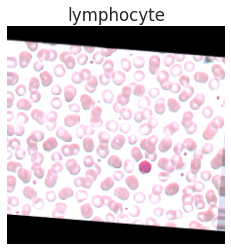

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


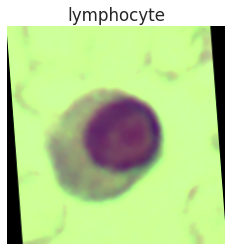

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


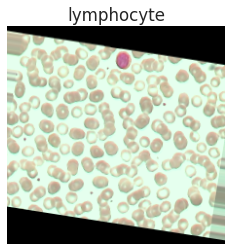

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


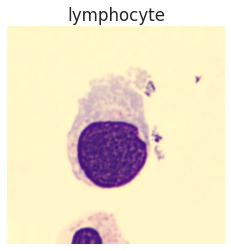

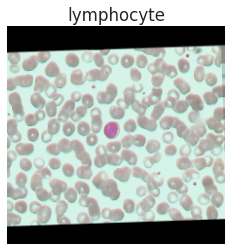

In [52]:
def get_images_with_labels_from_generator(gen, count=1):
    images_with_labels = []

    for c in range(0, count):

        imgs, one_hot_labels =  gen.send(None)

        i = 0
        for img, one_hot_label in zip(imgs, one_hot_labels):
            
            label = np.argmax(one_hot_labels[i])
            img = img * 255
            
            images_with_labels.append((img, label))
            i += 1

    return images_with_labels

for img, label in get_images_with_labels_from_generator(augmented_train_ds)[0:5]:
    show_image(img, decoding_cells_types_map[label])

### Custom CNN model with augmented data

In [53]:
tf.keras.backend.clear_session()

custom_cnn_with_augmented_data = get_custom_cnn()

custom_cnn_with_augmented_data.compile(
    optimizer = Adam(learning_rate=1e-5),
    loss = CategoricalCrossentropy(from_logits=False), 
    metrics = [CategoricalAccuracy()])

custom_cnn_with_augmented_data_h5 = get_models_dir("custom_cnn_with_augmented_data")

steps = math.ceil(len(train_data) / BATCH_SIZE)

history_custom_cnn_with_augmented_data = custom_cnn_with_augmented_data.fit(
    augmented_train_ds, 
    validation_data = val_ds,
    class_weight = class_weights,
    epochs = 10,
    steps_per_epoch = steps,
    callbacks = [ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-15, verbose=1),
                 ModelCheckpoint(custom_cnn_with_augmented_data_h5, verbose=1, save_weights_only=True, save_freq="epoch"),
                 TensorBoard(get_log_dir("custom_cnn_with_augmented_data"))])

Epoch 1/10
50/50 [==============================] - 11s 203ms/step - loss: 1.0173 - categorical_accuracy: 0.8713 - val_loss: 2.2297 - val_categorical_accuracy: 0.1735

Epoch 00001: saving model to drive/My Drive/Colab Notebooks/working/models/custom_cnn_with_augmented_data_02.26-09.18.54
Epoch 2/10
50/50 [==============================] - 10s 201ms/step - loss: 0.0679 - categorical_accuracy: 0.9895 - val_loss: 3.5848 - val_categorical_accuracy: 0.1735

Epoch 00002: saving model to drive/My Drive/Colab Notebooks/working/models/custom_cnn_with_augmented_data_02.26-09.18.54
Epoch 3/10
50/50 [==============================] - 10s 194ms/step - loss: 0.0227 - categorical_accuracy: 0.9987 - val_loss: 5.0406 - val_categorical_accuracy: 0.1735

Epoch 00003: saving model to drive/My Drive/Colab Notebooks/working/models/custom_cnn_with_augmented_data_02.26-09.18.54
Epoch 4/10
50/50 [==============================] - 10s 196ms/step - loss: 0.0405 - categorical_accuracy: 0.9922 - val_loss: 6.3375 -

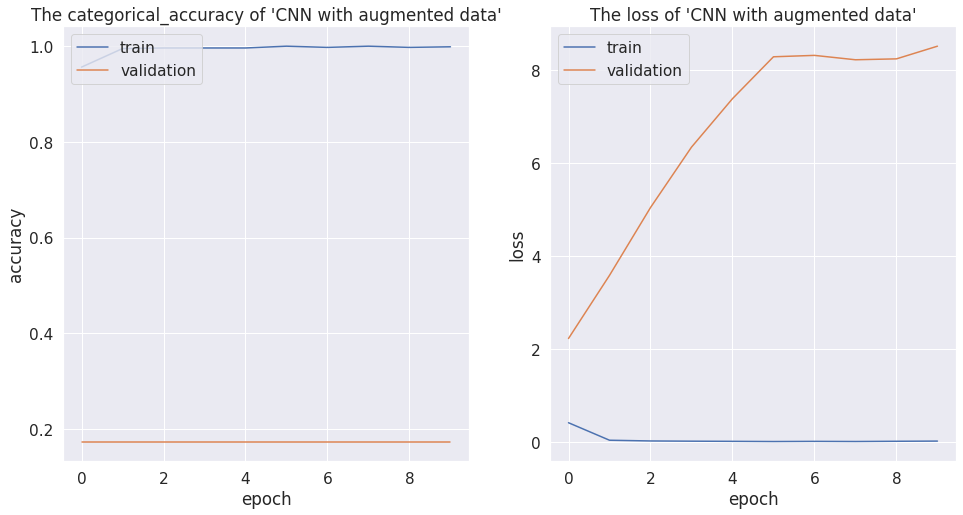

In [54]:
plot_learning_curve(history_custom_cnn_with_augmented_data, CategoricalAccuracy().name, "CNN with augmented data")

Out custom model is overfitting a lot the augmented data. Maybe if we try to simplify it a bit and increase dropout it can get better results.

In [55]:
tf.keras.backend.clear_session() # if the order of the execution of the cells is different from top to bottom

def get_updated_custom_cnn():
    
    def CustomConv2D(filters):
        return Conv2D(filters, 
                      kernel_size = (3, 3), 
                      padding = "same", 
                      activation = tf.nn.relu, 
                      kernel_regularizer=tf.keras.regularizers.L1L2(0.02),
                      kernel_initializer = HeNormal(seed=random_seed))
        
  
    return Sequential([
    
    Input(IMAGE_SIZE),

    CustomConv2D(16),
    MaxPool2D((2, 2)),
    BatchNormalization(),
    
    CustomConv2D(32),
    MaxPool2D((3, 3)),
    BatchNormalization(),
    
    CustomConv2D(64),
    MaxPool2D((4, 4)),
    BatchNormalization(),

    Flatten(),
    
    Dense(10, activation = tf.nn.relu,
          kernel_initializer=HeNormal(seed=random_seed)),
    Dropout(0.6, seed=random_seed),
    Dense(len(wbcs_types), activation = tf.nn.softmax,
          kernel_initializer=HeNormal(seed=random_seed))
  ])
    
custom_cnn_2_with_augmented_data = get_updated_custom_cnn()
custom_cnn_2_with_augmented_data.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        1

In [56]:
custom_cnn_2_with_augmented_data.compile(
    optimizer = Adam(learning_rate=1e-5),
    loss = CategoricalCrossentropy(from_logits=False), 
    metrics = [CategoricalAccuracy()])

custom_cnn_2_with_augmented_data_h5 = get_models_dir("custom_cnn_2_with_augmented_data")

steps = math.ceil(len(train_data) / BATCH_SIZE)

history_custom_2_with_augmented_data = custom_cnn_2_with_augmented_data.fit(
    augmented_train_ds, 
    validation_data = val_ds,
    class_weight = class_weights,
    epochs = 30,
    steps_per_epoch = steps,
    callbacks = [ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-15, verbose=1),
                 ModelCheckpoint(custom_cnn_with_augmented_data_h5, verbose=1, save_weights_only=True, save_freq="epoch"),
                 TensorBoard(get_log_dir("custom_cnn_with_augmented_data"))])

Epoch 1/30
50/50 [==============================] - 9s 173ms/step - loss: 40.3377 - categorical_accuracy: 0.5462 - val_loss: 38.1619 - val_categorical_accuracy: 0.1735

Epoch 00001: saving model to drive/My Drive/Colab Notebooks/working/models/custom_cnn_with_augmented_data_02.26-09.18.54
Epoch 2/30
50/50 [==============================] - 8s 170ms/step - loss: 39.0803 - categorical_accuracy: 0.6830 - val_loss: 38.4429 - val_categorical_accuracy: 0.1735

Epoch 00002: saving model to drive/My Drive/Colab Notebooks/working/models/custom_cnn_with_augmented_data_02.26-09.18.54
Epoch 3/30
50/50 [==============================] - 8s 168ms/step - loss: 38.3713 - categorical_accuracy: 0.7258 - val_loss: 38.7859 - val_categorical_accuracy: 0.1735

Epoch 00003: saving model to drive/My Drive/Colab Notebooks/working/models/custom_cnn_with_augmented_data_02.26-09.18.54
Epoch 4/30
50/50 [==============================] - 8s 171ms/step - loss: 38.4088 - categorical_accuracy: 0.6649 - val_loss: 39.09

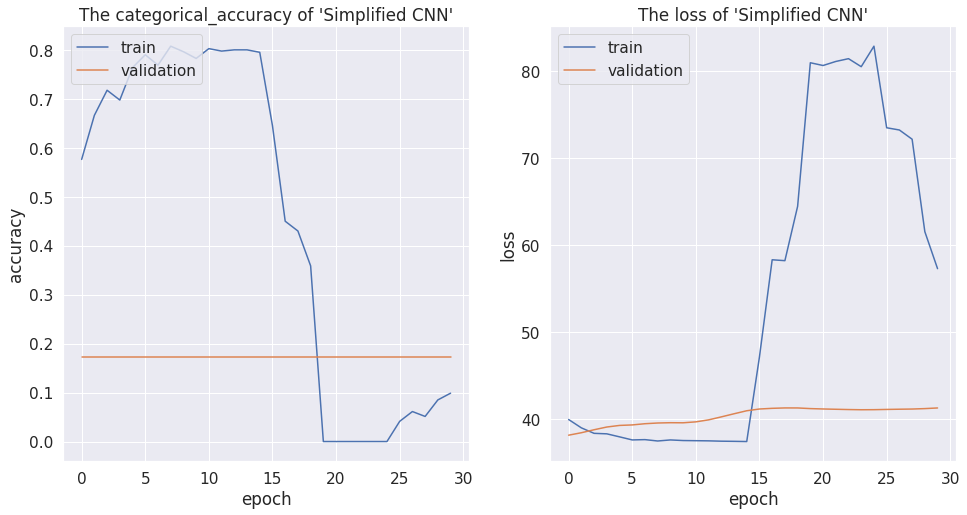

In [57]:
plot_learning_curve(history_custom_2_with_augmented_data, CategoricalAccuracy().name, "Simplified CNN")

#### Comments

Even with the simplified model we overfit the training data a lot. We should further investigate what is happening with the augmented data. Maybe, it is too different from our real data and the model learns features that do not generalize at all.

### Transfer Learning

We will try to retrain an existing model - VGG16 with our own data, using transfer learning. 

VGG takes in a 224x224 pixel RGB image. The model expects the images to be centered i.e. to have the mean pixel values from each channel (red, green, and blue) as calculated on the ImageNet training dataset subtracted from the input. 
For example, in ImageNet, per-channel means are pre-calculated across an entire training dataset both during training and any inference with the trained models in the future (ImageNet Training Dataset Means: [0.485, 0.456, 0.406])

However, the expectations are that VGG16 will overfit the augmented data even more.

#### Model

##### VGG16

In [84]:
tf.keras.backend.clear_session()

vgg_model = vgg16.VGG16()

Let's see the layers:

In [85]:
vgg_layers = {}
for i, layer in enumerate(vgg_model.layers):
    vgg_layers[layer.name] = i
vgg_layers

{'block1_conv1': 1,
 'block1_conv2': 2,
 'block1_pool': 3,
 'block2_conv1': 4,
 'block2_conv2': 5,
 'block2_pool': 6,
 'block3_conv1': 7,
 'block3_conv2': 8,
 'block3_conv3': 9,
 'block3_pool': 10,
 'block4_conv1': 11,
 'block4_conv2': 12,
 'block4_conv3': 13,
 'block4_pool': 14,
 'block5_conv1': 15,
 'block5_conv2': 16,
 'block5_conv3': 17,
 'block5_pool': 18,
 'fc1': 20,
 'fc2': 21,
 'flatten': 19,
 'input_1': 0,
 'predictions': 22}

##### Transfered Model

In [86]:
vgg_transfer = Model(
    inputs = vgg_model.layers[0].input, 
    outputs = vgg_model.layers[19].output)

In [87]:
vgg_transfer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Initially do not freeze the labels from VGG16, as we want to use mainly the  initial weights and otherwise the model is overfitting still in the first epoch.

In [88]:
for layer in vgg_transfer.layers:
    layer.trainable = True

In [89]:
transfer_model = Sequential([
    vgg_transfer,
    Dense(16, activation = "relu"),
    Dropout(0.5),
    Dense(len(wbcs_types), activation = "softmax")
])
transfer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 25088)             14714688  
_________________________________________________________________
dense (Dense)                (None, 16)                401424    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 15,116,197
Trainable params: 15,116,197
Non-trainable params: 0
_________________________________________________________________


#### Train

In [90]:
transfer_model.compile(
    optimizer = SGD(learning_rate=1e-5, momentum=0.5, nesterov=False), 
    loss = CategoricalCrossentropy(from_logits=False),
    metrics = [CategoricalAccuracy()])

Let's look at the initial valisation loss and accuracy

In [91]:
transfer_model.evaluate(val_ds)

7/7 [==============================] - 1s 64ms/step - loss: 1.8834 - categorical_accuracy: 0.0590


[1.6455796957015991, 0.16326530277729034]

In [92]:
def fit_transfer_model(transfer_model, epochs):
    steps =  math.ceil(len(train_data) / BATCH_SIZE) 

    return transfer_model.fit(
    augmented_train_ds,
    validation_data = val_ds,
    class_weight = class_weights,
    epochs = 10,
    steps_per_epoch = steps,
    callbacks = [ 
        ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-15, verbose=1),
        ModelCheckpoint(transfer_model_h5, verbose=1, save_weights_only=True, save_freq="epoch"),
        TensorBoard(get_log_dir("transfer_cnn_model"))
    ])

In [93]:
transfer_model_h5 = get_models_dir("transfer_model")

history_transfer_model = fit_transfer_model(transfer_model, 10)

Epoch 1/10
50/50 [==============================] - 13s 248ms/step - loss: 3.4661 - categorical_accuracy: 0.3487 - val_loss: 1.6276 - val_categorical_accuracy: 0.1735

Epoch 00001: saving model to drive/My Drive/Colab Notebooks/working/models/transfer_model_02.26-09.32.55
Epoch 2/10
50/50 [==============================] - 13s 254ms/step - loss: 2.7078 - categorical_accuracy: 0.5150 - val_loss: 1.7720 - val_categorical_accuracy: 0.1735

Epoch 00002: saving model to drive/My Drive/Colab Notebooks/working/models/transfer_model_02.26-09.32.55
Epoch 3/10
50/50 [==============================] - 13s 253ms/step - loss: 2.4485 - categorical_accuracy: 0.5738 - val_loss: 1.9028 - val_categorical_accuracy: 0.1735

Epoch 00003: saving model to drive/My Drive/Colab Notebooks/working/models/transfer_model_02.26-09.32.55
Epoch 4/10
50/50 [==============================] - 13s 252ms/step - loss: 2.1962 - categorical_accuracy: 0.6425 - val_loss: 2.0444 - val_categorical_accuracy: 0.1735

Epoch 00004: 

#### Visualizations and tests

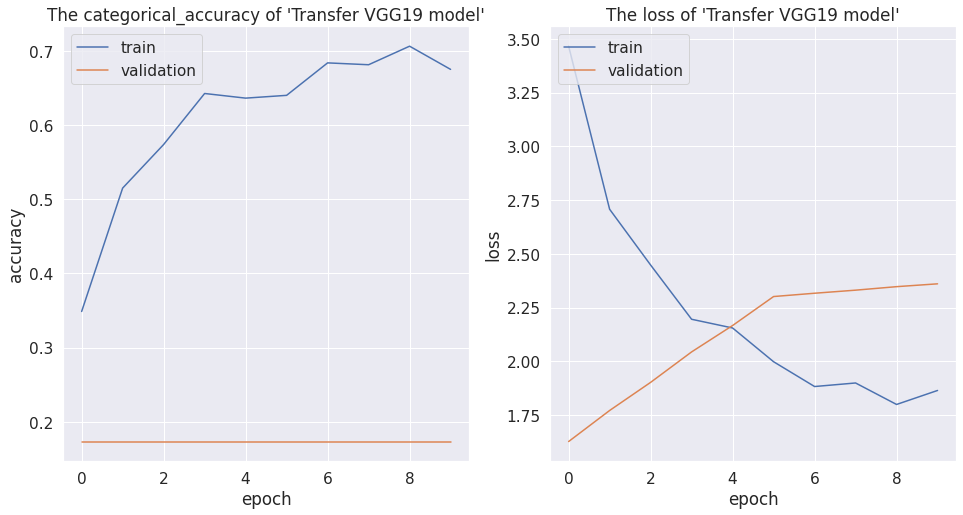

In [94]:
plot_learning_curve(history_transfer_model, CategoricalAccuracy().name, "Transfer VGG19 model")

#### Comments

Unfortunately, as expected VGG16 overfit the data even with image augmentation.

## Conclusion

Cell classification is an important process toward further investigation of possible models for helping diagnoses for different types of blood cell. In this notebook, we try to create a deep learning supervised model to differentiate between five main types of white blood cells, unfortunately without any success.

## Bibliography


1. Karen Simonyan & Andrew Zisserman, Very Deep Convolutional Networks for Large-Scale Image Recognition - https://arxiv.org/pdf/1409.1556.pdf

2. Connor Shorten & Taghi M. Khoshgoftaar, A survey on Image Data Augmentation for Deep Learning https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0

3. Jason Brownlee PhD, Machine Learning Mastery - https://machinelearningmastery.com/

4. Pascal Andre Dufour - https://stepup.ai/

5. OpenCV tutorials and documentation: 
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html + https://docs.opencv.org/master/

6. Sreenivas Bhattiprolu, Python for Microscopists: https://www.youtube.com/channel/UC34rW-HtPJulxr5wp2Xa04w

7. Fei-Fei Li - http://cs231n.stanford.edu/